
# Demo: Color Quantization using K-Means and GMM

This demo is modified from the code by Layton et al.,
https://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html

The goal is to perform Vector Quantization (VQ) of pixel in an image in order to reduce the number of colors from 96615 to 16.  

In particular, each pixel has a feature vector consisting of 3 quantized color components (i.e., RGB).  Originally, there are 96615 unique color combinations.  In order to reduce the storage requirements for the image, one may want to reduce the number of unique color combinations.  We can think about this as a clustering problem: Using a subset of pixels, we cluster the RGB features down to 16 unique centroids.  Then each RBG pixel is replaced by one of these 16 colors.  In the image processing literature, the codebook containing the color combinations is called the color palette.  

For clustering, we try both the k-means and EM-GMM methods. As a baseline, a quantized image using randomly chosen colors is also shown.


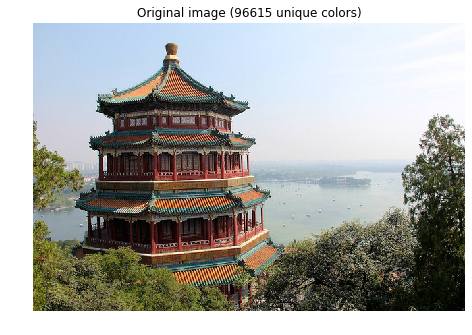

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from time import time
from sklearn.mixture import GaussianMixture

n_colors = 16

# Load the Summer Palace photo
china = load_sample_image("china.jpg")

# Compute number of unique colors
china_vec_rgb = np.reshape(china,[-1,3])
china_vec = china_vec_rgb[:,0]+256*china_vec_rgb[:,1]+256*256*china_vec_rgb[:,2]
n_colors_orig = len(np.unique(china_vec))

# Plot photo
plt.figure(1)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Original image (%d unique colors)' % n_colors_orig)
plt.imshow(china)
plt.show()

In [2]:
# This function replaces each pixel by its predicted pixel (the cluster mean of the cluster that this pixel belongs to)

def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

In [3]:
# Preprocessing the data for clustering

# Convert to floats instead of the default 8 bits integer coding. Dividing by
# 255 is important so that plt.imshow behaves works well on float data (need to
# be in the range [0-1])
china = np.array(china, dtype=np.float64) / 255

# Load Image and transform to a 2D numpy array.
w, h, d = original_shape = tuple(china.shape)
assert d == 3
image_array = np.reshape(china, (w * h, d))

# Take a small subset of the pixels
n_samp = 1000
image_array_sample = shuffle(image_array, random_state=0)[:n_samp]

Kmeans: Fitting model on a small sub-sample of the data
Done in 0.075s.
Kmeans: Predicting color indices on the full image
Done in 0.052s.


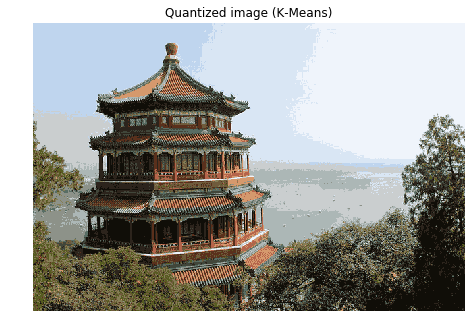

In [4]:
# Clustering using K-means

print("Kmeans: Fitting model on a small sub-sample of the data")
t0 = time()
kmeans = KMeans(n_clusters=n_colors,  init='k-means++', n_init=10, max_iter=300, random_state=0)
#kmeans = KMeans(n_clusters=n_colors)
kmeans.fit(image_array_sample)
print("Done in %0.3fs." % (time() - t0))

# Get labels for all points
print("Kmeans: Predicting color indices on the full image")
t0 = time()
kmeans_labels = kmeans.predict(image_array)
print("Done in %0.3fs." % (time() - t0))

china_kmeans = recreate_image(kmeans.cluster_centers_, kmeans_labels, w, h)

plt.figure(2)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Quantized image (K-Means)')
plt.imshow(china_kmeans)
plt.show()

GMM: Fitting model on a small sub-sample of the data
Done in 0.029s.
GMM: Predicting color indices on the full image (GMM)
Done in 0.080s.


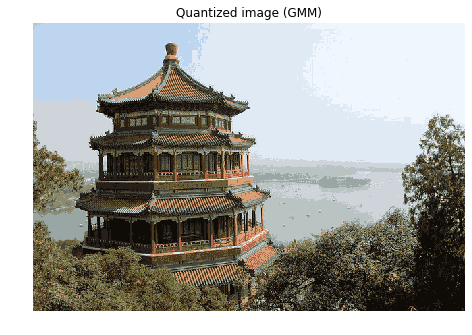

In [5]:
# Clustering using GMM, with K-means results as initial mixture mean

print("GMM: Fitting model on a small sub-sample of the data")
t0 = time()

GMM = GaussianMixture(n_components=n_colors,
                   covariance_type = 'diag', max_iter=100, random_state=0, init_params = 'kmeans')

GMM.fit(image_array_sample)
print("Done in %0.3fs." % (time() - t0))

# Get labels for all points
print("GMM: Predicting color indices on the full image (GMM)")
t0 = time()
GMM_labels = GMM.predict(image_array)
print("Done in %0.3fs." % (time() - t0))

china_gmm = recreate_image(GMM.means_, GMM_labels, w, h)

plt.figure(3)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Quantized image (GMM)')
plt.imshow(china_gmm)
plt.show()

Predicting color indices on the full image (random)
Done in 0.048s.


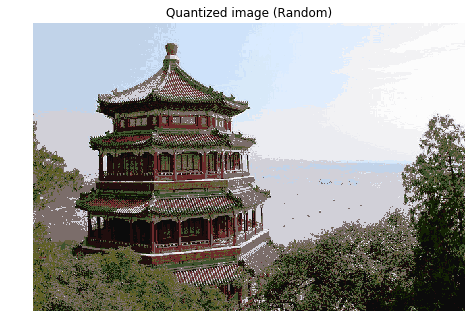

In [6]:
# Using Random Samples as cluster centers, and nearest neighbor to assign clusters

codebook_random = shuffle(image_array, random_state=0)[:n_colors + 1]
print("Predicting color indices on the full image (random)")
t0 = time()
labels_random = pairwise_distances_argmin(codebook_random,
                                          image_array,
                                          axis=0)
print("Done in %0.3fs." % (time() - t0))

china_random = recreate_image(codebook_random, labels_random, w, h)

plt.figure(4)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Quantized image (Random)')
plt.imshow(china_random)
plt.show()

Side-by side comparison:

Text(0.5, 1.0, 'Quantized image (GMM)')

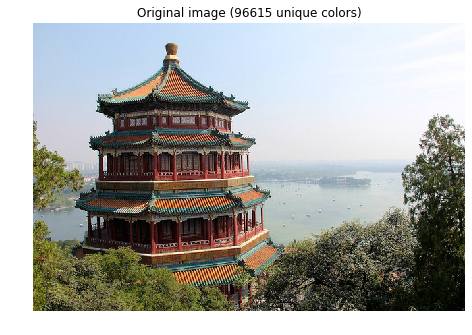

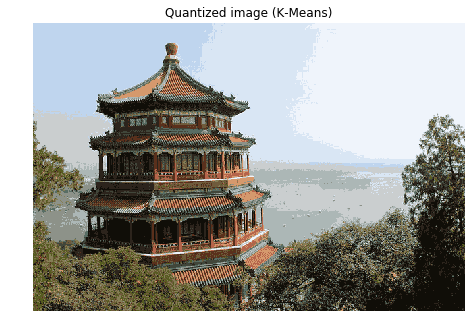

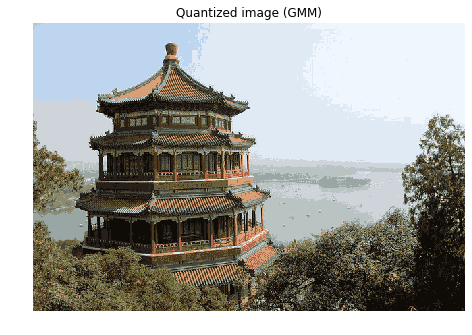

In [7]:
plt.figure()
plt.axes([0, 0, 1, 1])
plt.imshow(china)
plt.axis('off')
plt.title('Original image (%d unique colors)' % n_colors_orig)

plt.figure()
plt.axes([0, 0, 1, 1])
plt.imshow(china_kmeans)
plt.axis('off')
plt.title('Quantized image (K-Means)')

plt.figure()
plt.axes([0, 0, 1, 1])
plt.imshow(china_gmm)
plt.axis('off')
plt.title('Quantized image (GMM)')